In [18]:
import pandas as pd
from dask import delayed, compute, visualize
import os
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Managing Challenges with Large Files
## Load Dataset

In [6]:
df = pd.read_excel("data/orig/EMHIRES_WIND_COUNTRY_June2019.xlsx")
df.head()

,Time_step,Date,Year,Month,Day,Hour,AL,AT,BE,BG,...,NL,NO,PL,PT,RO,RS,SE,SI,SK,UK
0,1,1986-01-01,1986,1,1,0,0.3685,0.06084,0.25200,0.23762,...,0.40628,0.26292,0.12015,0.22683,0.05124,0.25050,0.17086,0.67720,0.05715,0.268794
1,2,1986-01-01,1986,1,1,1,0.3235,0.05282,0.23841,0.23842,...,0.39115,0.26376,0.11985,0.25821,0.04665,0.24625,0.15909,0.66776,0.05218,0.270761
2,3,1986-01-01,1986,1,1,2,0.2735,0.04276,0.22110,0.23033,...,0.36163,0.26695,0.12113,0.27921,0.04543,0.23250,0.15296,0.65904,0.03905,0.265209
3,4,1986-01-01,1986,1,1,3,0.2600,0.02914,0.21491,0.24158,...,0.35170,0.27101,0.11858,0.33106,0.04455,0.20525,0.15328,0.58460,0.02130,0.257709
4,5,1986-01-01,1986,1,1,4,0.2530,0.01780,0.20304,0.26168,...,0.36168,0.28097,0.11101,0.38668,0.05438,0.20075,0.15013,0.46732,0.01029,0.247726


## Splitting on Data

### Approach 1: Nested For-Loop

In [15]:
for country in df.columns[6:]:
    for year, ds in tqdm(df.groupby('Year'), desc=country):
        dset = ds[['Date', 'Year', country]]
        os.makedirs(f'data/processed/{country}', exist_ok=True)
        (dset
         .rename(columns={country: 'WindFactor'})
         .assign(Country=country, Year=year)
         .to_csv(f'data/processed/{country}/Onshort-{country}-{year}.csv', index=False)
        )

UK: 100%|██████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.25it/s]


### Approach 2: Nested For-Loop + Dask Delayed

In [17]:
def get_all_windfactors_by_country(ds, country, year):
            dset = ds[['Date', 'Year', country]]
            os.makedirs(f'data/processed/{country}', exist_ok=True)
            (dset
             .rename(columns={country: 'WindFactor'})
             .assign(Country=country, Year=year)
             .to_csv(f'data/processed/{country}/Onshort-{country}-{year}.csv', index=False)
            )

delayed_list = []
            
for country in df.columns[6:]:
    for year, ds in tqdm(df.groupby('Year'), desc=country):
        delayed_list.append(delayed(get_all_windfactors_by_country)(ds, country, year))
        
        
with ProgressBar():
    compute(*delayed_list)

UK: 100%|█████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 405.41it/s]


(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

### Approach 3: Tidy Pipeline + For-Loop

### Approach 4: Tidy Pipeline + For-Loop + Dask Delayed

### Approach 5: Linearized Pipeline

### Approach 6: Linearized Pipeline + Dask DataFrame

## Working with Split Files Out-of-Core with Dask DataFrame
When the data is consistently organized, Dask DataFrame lets you pretend that all the files are a single pandas dataframe, keeping code simple

In [23]:
df = dd.read_csv(r"data/processed/*/*.csv")
df

,Date,Year,WindFactor,Country
npartitions=1080,,,,
,object,int64,float64,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0476052 to fit


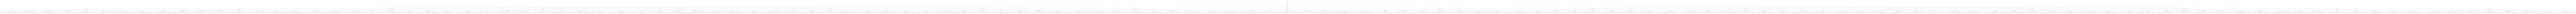

In [30]:
df.groupby("Country")["WindFactor"].mean().mean().visualize()